In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from src.text_preprocessor import TextPreprocessor
from src.text_vectorizer import TextVectorizer
from src.classifier_model import LSTMClassifierModel

from src.eval_utils import evaluate_multi_classif
from src.plot_utils import plot_categories, plot_w2v


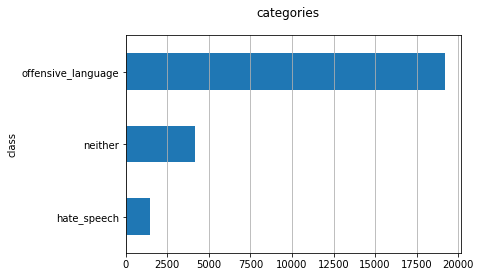

In [2]:
 # load data
df = pd.read_csv('data/t_davidson_hate_speech_and_offensive_language.csv', index_col=0)
plot_categories(df)

sentences = df['tweet']
mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
y = df[['class']]
y = y.replace({'class': mapping})['class']

In [3]:
# split into train and test (the val set will be taken from `sentences_train` during training)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.1, random_state=1000)

In [4]:
# initialize sklearn preprocessing pipeline
nltk_stop_words = pd.read_csv('data/nltk_stop_words.csv', header=None).iloc[0].tolist()
preprocess_pipeline = Pipeline(steps=[
    ('normalize', TextPreprocessor(custom_stop_words=nltk_stop_words + ['rt', 'amp', 'ai', 'nt', 'na'])),
    ('features', TextVectorizer()),
])

# initialize sklearn classifier pipeline
classifier_pipeline = Pipeline(steps=[
    ('preprocessing', preprocess_pipeline),
    ('classifier', LSTMClassifierModel(encode_y=True, epochs=15, batch_size=128))
])

C:\Users\ng5ef3d\Documents\dan\python\hate_speech_v2\src\text_vectorizer.py:136: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=self.df_ngrams.groupby('ngrams')['ngrams', 'freq', 'word'].head(10))


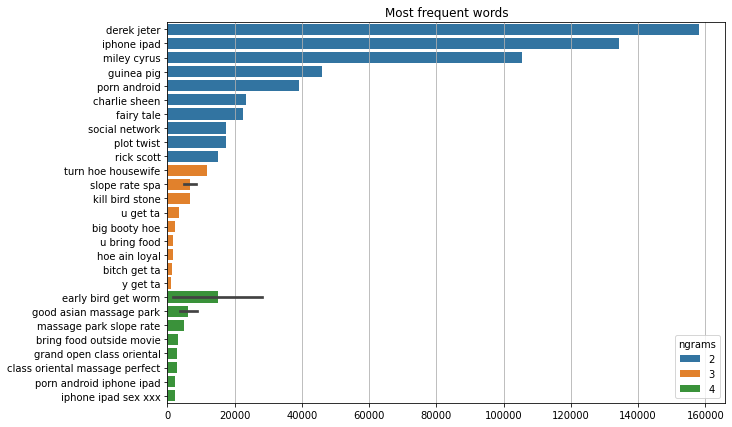

--- tokenization ---
15681 words
--- padding to sequence ---
22304 sequences of length 15


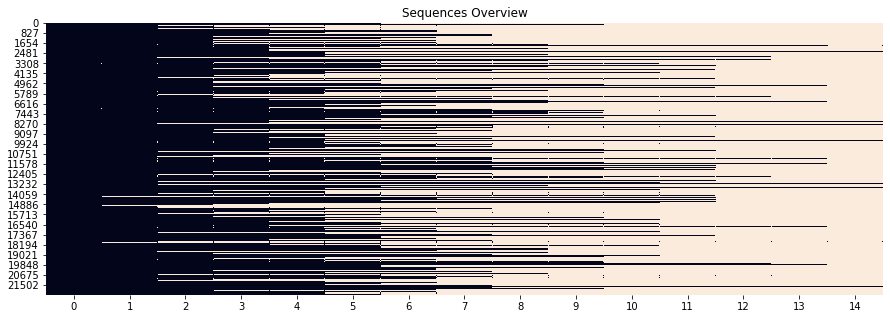

vocabulary mapped to 15682 vectors of size 300
{0: 'hate_speech', 1: 'neither', 2: 'offensive_language'}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      4704600     input_1[0][0]                    
__________________________________________________________________________________________________
attention (Attention)           (None, 15, 300)      0           embedding[0][0]                  
                                                                 embedding[0][0]                  
________________________________________________________________________________________

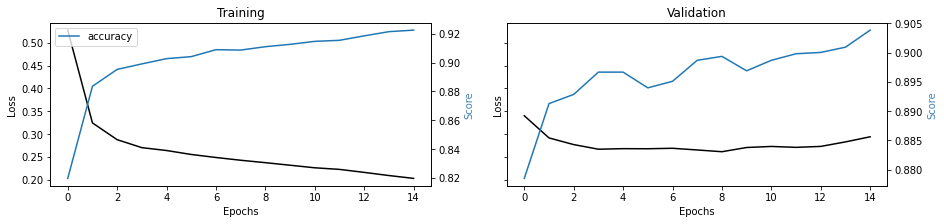

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('normalize',
                                  TextPreprocessor(custom_stop_words=['ourselves',
                                                                      'hers',
                                                                      'between',
                                                                      'yourself',
                                                                      'but',
                                                                      'again',
                                                                      'there',
                                                                      'about',
                                                                      'once',
                                                                      'during',
                                                                      'out',
                                              

In [5]:
# train model
classifier_pipeline.fit(sentences_train, y_train)
plt.show()

c:\users\ng5ef3d\programs\miniconda3\envs\hate_speech\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


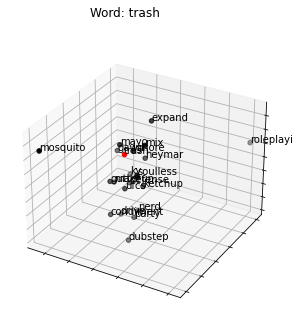

In [13]:
# plot word clouds
nlp = classifier_pipeline['preprocessing']['features'].nlp
plot_w2v(lst_words=['trash'], nlp=nlp, plot_type="3d", top=20, annotate=True, figsize=(20, 5))

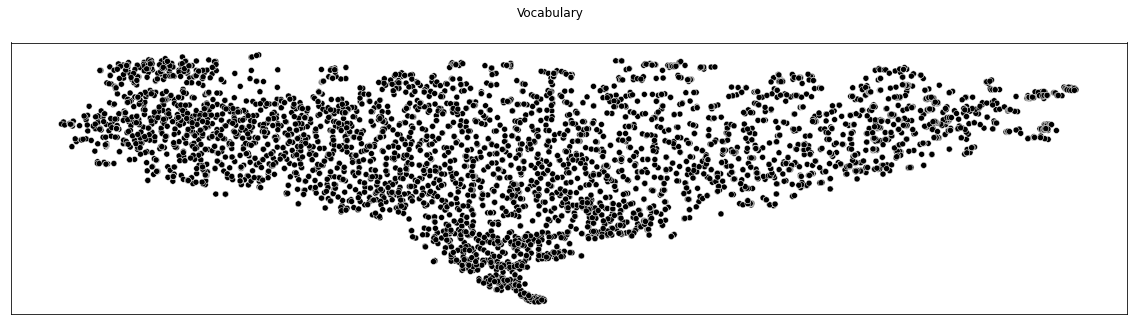

In [14]:
plot_w2v(lst_words=None, nlp=nlp.wv, plot_type="2d", annotate=False, figsize=(20, 5))

C:\Users\ng5ef3d\Documents\dan\python\hate_speech_v2\src\text_vectorizer.py:136: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=self.df_ngrams.groupby('ngrams')['ngrams', 'freq', 'word'].head(10))


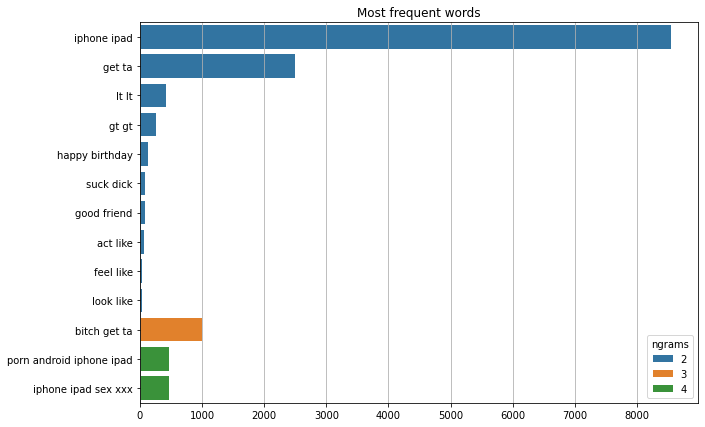

--- tokenization ---
15681 words
--- padding to sequence ---
2479 sequences of length 15


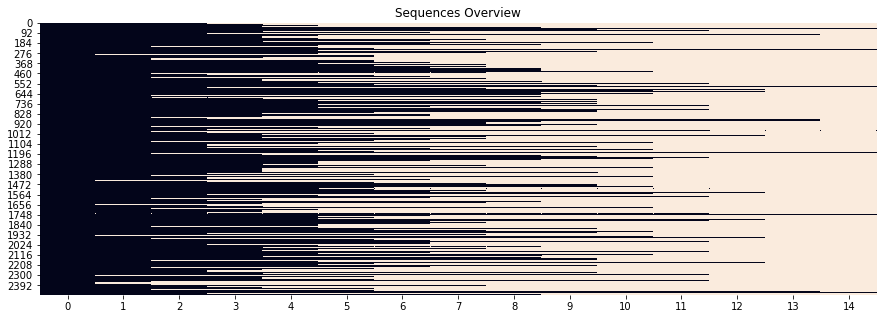

vocabulary mapped to 15682 vectors of size 300


In [6]:
# preprocess test vector
X_test, _ = preprocess_pipeline.fit_transform(sentences_test)

In [7]:
# run inference
predicted_prob, predicted = classifier_pipeline['classifier'].predict(X_test)

Accuracy: 0.9
Auc: 0.94
Detail:
                    precision    recall  f1-score   support

       hate_speech       0.50      0.13      0.21       131
           neither       0.81      0.90      0.85       438
offensive_language       0.93      0.95      0.94      1910

          accuracy                           0.90      2479
         macro avg       0.75      0.66      0.67      2479
      weighted avg       0.89      0.90      0.89      2479



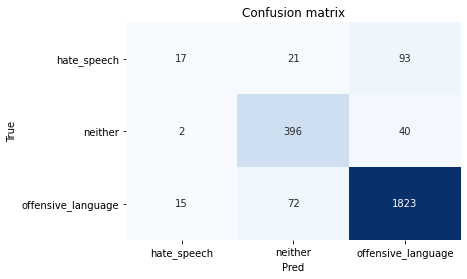

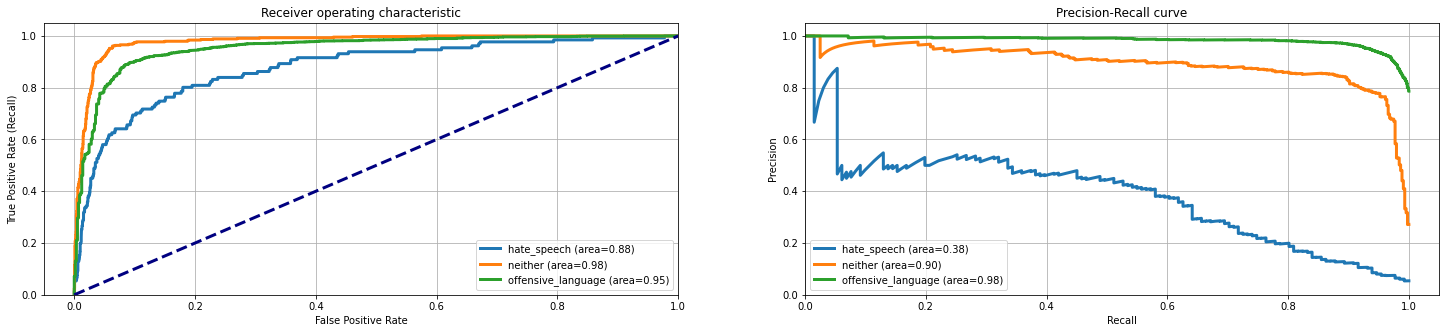

In [9]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(25, 5))